In [4]:
pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.2 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256

In [5]:
from medmnist import PneumoniaMNIST
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [6]:
# Definir o tamanho da janela para extração de características
WINDOW_SIZE = 16
# Definir o número de clusters para segmentação
N_CLUSTERS = 2
# Definir path para salvar imagens
SAVE_DIR = 'imagens'

# Criar filtros de Gabor em diferentes orientações e escalas
def create_gabor_filters():
    filters = []
    ksize = 31

    # Definir diferentes orientações (em graus)
    thetas = [0, 45, 90, 135]  # 0° (horizontal), 45°, 90° (vertical), 135°

    # Definir diferentes escalas (lambdas)
    lambdas = [3, 6, 12]  # Três escalas diferentes

    # Criar filtros de Gabor para cada combinação de orientação e escala
    for theta in thetas:
        for lambd in lambdas:
            # Converter graus para radianos
            theta_rad = theta * np.pi / 180

            # Criar filtro de Gabor
            kern = cv2.getGaborKernel(
                (ksize, ksize),
                sigma=lambd/3,
                theta=theta_rad,
                lambd=lambd,
                gamma=0.5,
                psi=0,
                ktype=cv2.CV_32F
            )

            # Normalizar o kernel
            kern /= 1.5*kern.sum()

            # Adicionar à lista de filtros
            filters.append((kern, f"{theta}°_lambda{lambd}"))


    # Criar filtro circular (LoG - Laplacian of Gaussian)
    for sigma in [1, 2, 4]:  # Três escalas para o filtro circular
        size = int(ksize / 2)
        x = np.arange(-size, size + 1)

        # Criar filtro gaussiano 1D
        gaussian_1d = np.exp(-(x**2) / (2.0 * sigma**2))
        gaussian_1d = gaussian_1d / np.sum(gaussian_1d)  # Normalizar

        # Criar filtro LoG 1D
        log_1d = -(x**2 / sigma**4 - 1 / sigma**2) * gaussian_1d
        log_1d = log_1d - np.mean(log_1d)  # Garantir que a soma seja zero

        # Criar filtros 2D separáveis
        kernel_h = log_1d.reshape(1, -1)  # Filtro horizontal
        kernel_v = log_1d.reshape(-1, 1)  # Filtro vertical

        filters.append((kernel_h, f"circular_sigma{sigma}_h"))
        filters.append((kernel_v, f"circular_sigma{sigma}_v"))

    return filters

# Processar uma imagem com filtros de Gabor
def apply_gabor_filters(image, filters):
    # Garantir que a imagem seja float32 para evitar overflow
    image = image.astype(np.float32)

    results = []

    # Aplicar cada filtro na imagem
    for kernel, name in filters:
        # Aplicar convolução
        filtered = cv2.filter2D(image, cv2.CV_32F, kernel)

        # Tomar o valor absoluto da resposta para detectar bordas em qualquer direção
        filtered = np.abs(filtered)

        # Normalizar para visualização
        filtered = cv2.normalize(filtered, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        results.append((filtered, name))

    return results

# Extrair características de textura de uma imagem usando filtros
def extract_texture_features(image, filters):
    # Aplicar filtros
    filtered_images = apply_gabor_filters(image, filters)

    # Determinar a quantidade de janelas em cada dimensão
    h, w = image.shape
    windows_h = h // WINDOW_SIZE
    windows_w = w // WINDOW_SIZE

    # Inicializar matriz de características
    # Cada janela terá um vetor de características (média de cada filtro)
    features = np.zeros((windows_h, windows_w, len(filters)))

    # Para cada janela, calcular características
    for i in range(windows_h):
        for j in range(windows_w):
            # Definir coordenadas da janela
            y_start = i * WINDOW_SIZE
            y_end = (i + 1) * WINDOW_SIZE
            x_start = j * WINDOW_SIZE
            x_end = (j + 1) * WINDOW_SIZE

            # Para cada filtro, calcular a média da resposta na janela
            for k, (filtered_img, _) in enumerate(filtered_images):
                window = filtered_img[y_start:y_end, x_start:x_end]
                features[i, j, k] = np.mean(window)

    return features, filtered_images

# Agrupar regiões com base nas características de textura
def cluster_regions(features, n_clusters=N_CLUSTERS):
    # Verificar se temos exemplos suficientes para o número desejado de clusters
    h, w, n_features = features.shape
    n_samples = h * w

    # Se não tivermos exemplos suficientes, reduzir o número de clusters
    actual_n_clusters = min(n_clusters, n_samples)
    if actual_n_clusters < n_clusters:
        print(f"Aviso: Reduzindo número de clusters de {n_clusters} para {actual_n_clusters} devido ao número limitado de amostras.")

    # Remodelar o array para matriz 2D onde cada linha é um vetor de características
    features_flat = features.reshape(n_samples, n_features)

    # Padronizar as características
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_flat)

    # Aplicar K-means
    kmeans = KMeans(n_clusters=actual_n_clusters, random_state=42)
    labels = kmeans.fit_predict(features_scaled)

    # Remodelar os rótulos de volta para a forma da imagem
    segmented = labels.reshape(h, w)

    # Obter os centróides dos clusters (características médias de cada grupo)
    centroids = kmeans.cluster_centers_

    return segmented, centroids, kmeans, actual_n_clusters

def visualize_results(image,
                               filtered_images,
                               segmented,
                               true_label,
                               save_dir=None,
                               prefix='result',
                               dpi=300):

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    fig = plt.figure(figsize=(20, 12))
    plt.subplot(2, 4, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Original ({"Pneumonia" if true_label==1 else "Normal"})')
    plt.axis('off')

    # Exemplos de filtros
    filter_indices = [0, len(filtered_images)//2, -1]
    for i, idx in enumerate(filter_indices):
        plt.subplot(2, 4, i+2)
        img_f, name = filtered_images[idx]
        plt.imshow(img_f, cmap='jet')
        plt.title(name)
        plt.axis('off')

    # Segmentação
    plt.subplot(2, 4, 5)
    plt.imshow(segmented, cmap='nipy_spectral')
    plt.title('Segmentação')
    plt.axis('off')

    # Sobreposição
    plt.subplot(2, 4, 6)
    h, w = image.shape
    seg_full = np.kron(segmented, np.ones((WINDOW_SIZE, WINDOW_SIZE), dtype=np.uint8))
    seg_full = seg_full[:h, :w]
    plt.imshow(image, cmap='gray')
    plt.imshow(seg_full, cmap='nipy_spectral', alpha=0.5)
    plt.title('Sobreposta')
    plt.axis('off')

    # Histograma
    plt.subplot(2, 4, 7)
    uni, cnt = np.unique(segmented, return_counts=True)
    plt.bar(uni, cnt)
    plt.title('Distribuição de Clusters')
    plt.xlabel('Cluster')
    plt.ylabel('Regiões')

    plt.tight_layout()

    # Salvando em PNG e EPS
    if save_dir:
        for ext in ('png', 'eps'):
            fname = os.path.join(save_dir, f"{prefix}.{ext}")
            fig.savefig(fname, format=ext, dpi=dpi, bbox_inches='tight')
            print(f"Salvo: {fname}")

    plt.show()
    plt.close(fig)


In [7]:
# Função para carregar os datasets
def load_datasets(train_amount=100, test_amount=100, size=64):
    dt_train = PneumoniaMNIST(split='train', download=True, size=size)
    dt_test  = PneumoniaMNIST(split='test',  download=True, size=size)
    X_train = dt_train.imgs[:train_amount]
    y_train = dt_train.labels[:train_amount].squeeze()
    X_test  = dt_test.imgs[:test_amount]
    y_test  = dt_test.labels[:test_amount].squeeze()
    return X_train, y_train, X_test, y_test

# Preparar features de todos os patches do treino
def prepare_training_features(images, filters):
    feats_list = []
    for img in images:
        img8 = cv2.normalize(img.squeeze(), None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        feats, _ = extract_texture_features(img8, filters)
        h, w, d = feats.shape
        feats_list.append(feats.reshape(h*w, d))
    return np.vstack(feats_list)

# Treinar um KMeans global
def train_kmeans_global(features, n_clusters=2):
    scaler = StandardScaler()
    F = scaler.fit_transform(features)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(F)
    return kmeans, scaler

# Calcular distribuição de clusters em uma imagem
def compute_distribution(img, filters, kmeans, scaler):
    img8 = cv2.normalize(img.squeeze(), None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    feats, _ = extract_texture_features(img8, filters)
    h, w, d = feats.shape
    flat = feats.reshape(h*w, d)
    flat_s = scaler.transform(flat)
    preds = kmeans.predict(flat_s)
    dist = np.bincount(preds, minlength=kmeans.n_clusters) / (h*w)
    return dist

# Função para plotar a distribuição média de clusters
def plot_avg_cluster_distribution(
    avg_normal,
    avg_pneumonia,
    save_dir=None,
    prefix='avg_cluster_distribution',
    dpi=300
):
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
    # Dados para o gráfico
    x = np.arange(len(avg_normal))
    width = 0.35
    # Figura
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, avg_normal, width, label='Normal')
    ax.bar(x + width/2, avg_pneumonia, width, label='Pneumonia')
    ax.set_xlabel('Cluster ID')
    ax.set_ylabel('Frequência Média')
    ax.set_title('Distribuição média de clusters por diagnóstico')
    ax.set_xticks(x)
    ax.legend()
    fig.tight_layout()
    # Salvando em PNG e EPS
    if save_dir:
        for ext in ('png', 'eps'):
            fname = os.path.join(save_dir, f"{prefix}.{ext}")
            fig.savefig(fname, format=ext, dpi=dpi, bbox_inches='tight')
            print(f"Salvo: {fname}")
    # Exibir
    plt.show()
    plt.close(fig)



## Teste treinando Kmeans Local

100%|██████████| 20.6M/20.6M [00:01<00:00, 13.5MB/s]


Matriz de Confusão:
[[52 31]
 [37 80]]

Verdadeiros Positivos (TP): 80
Verdadeiros Negativos (TN): 52
Falsos Positivos    (FP): 31
Falsos Negativos    (FN): 37

Acurácia: 66.00%


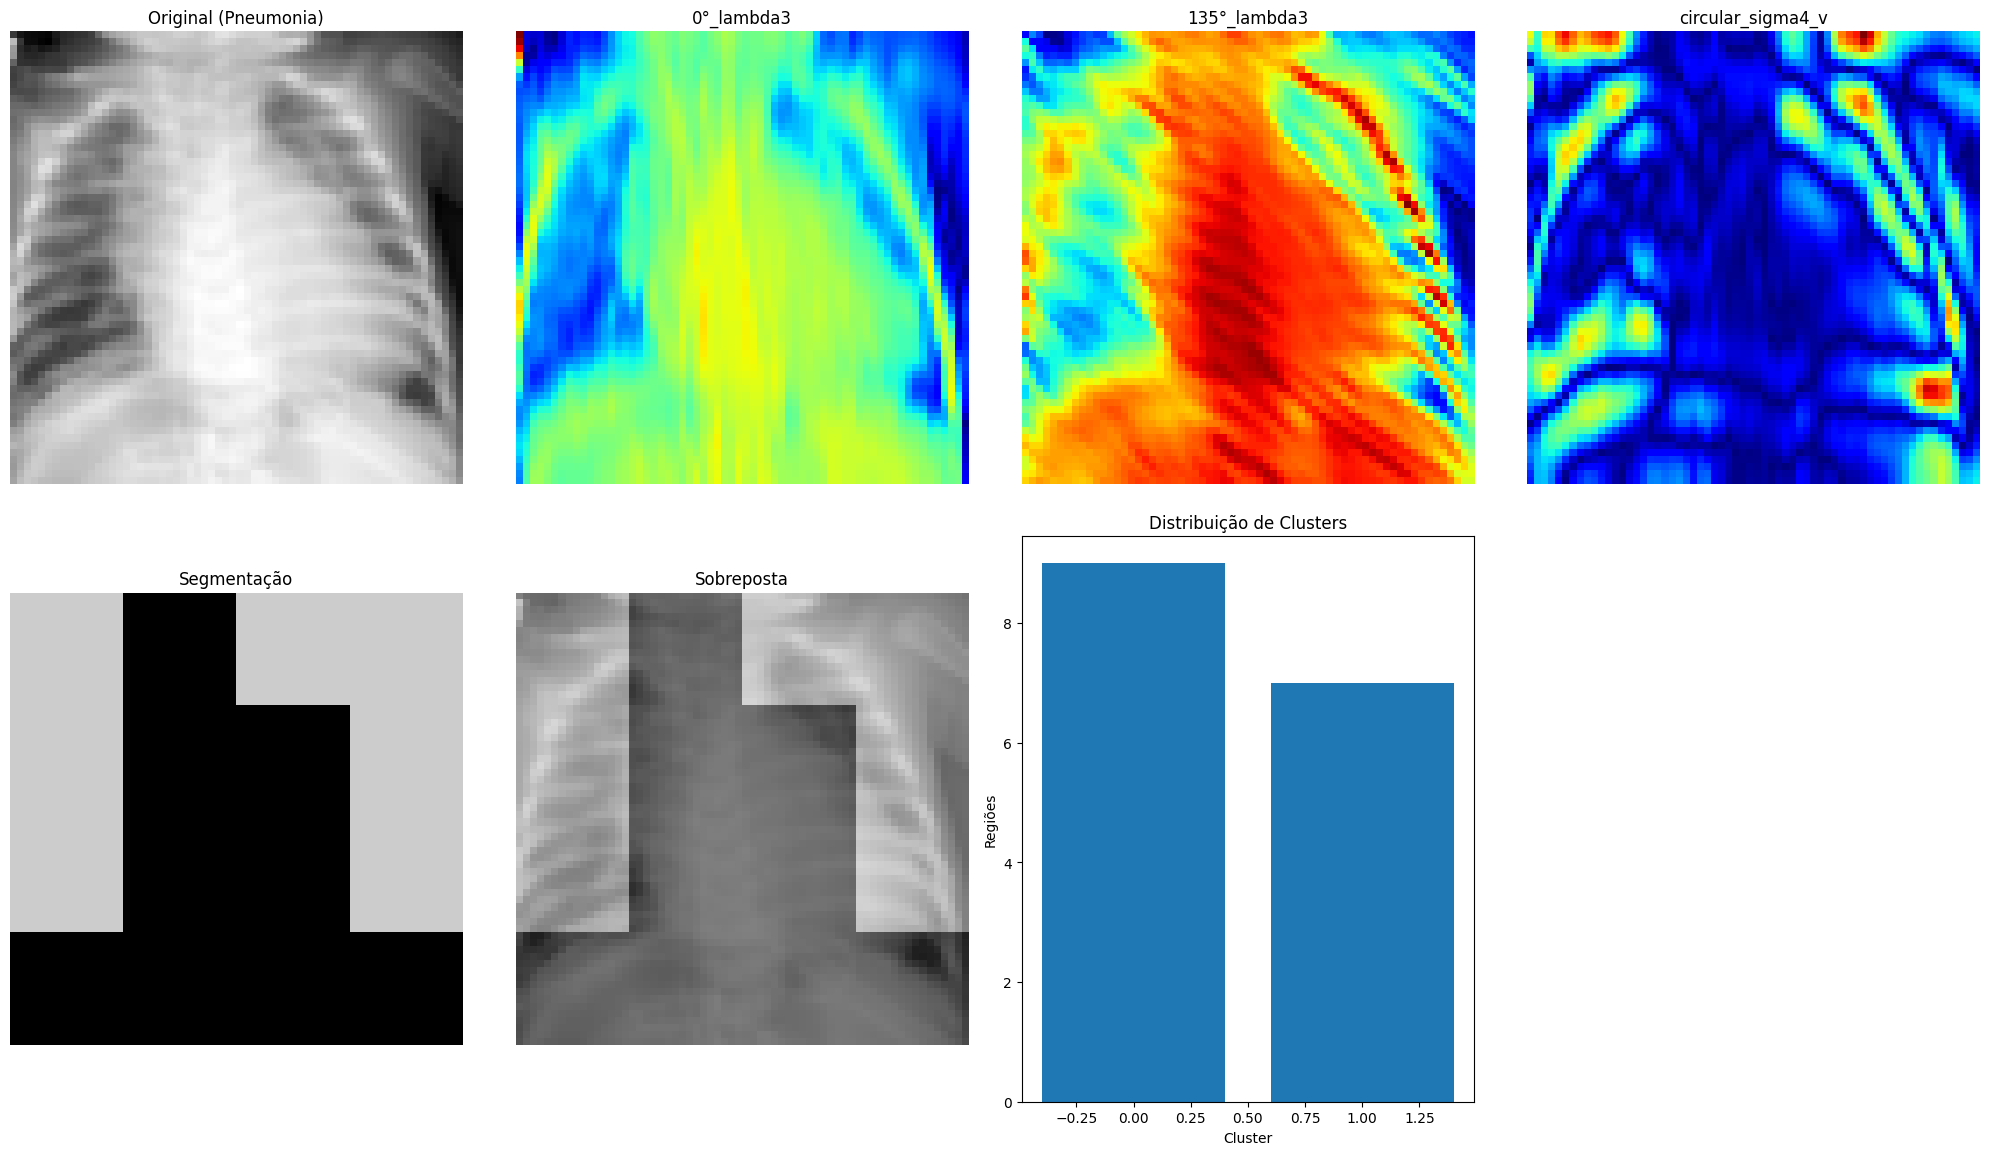

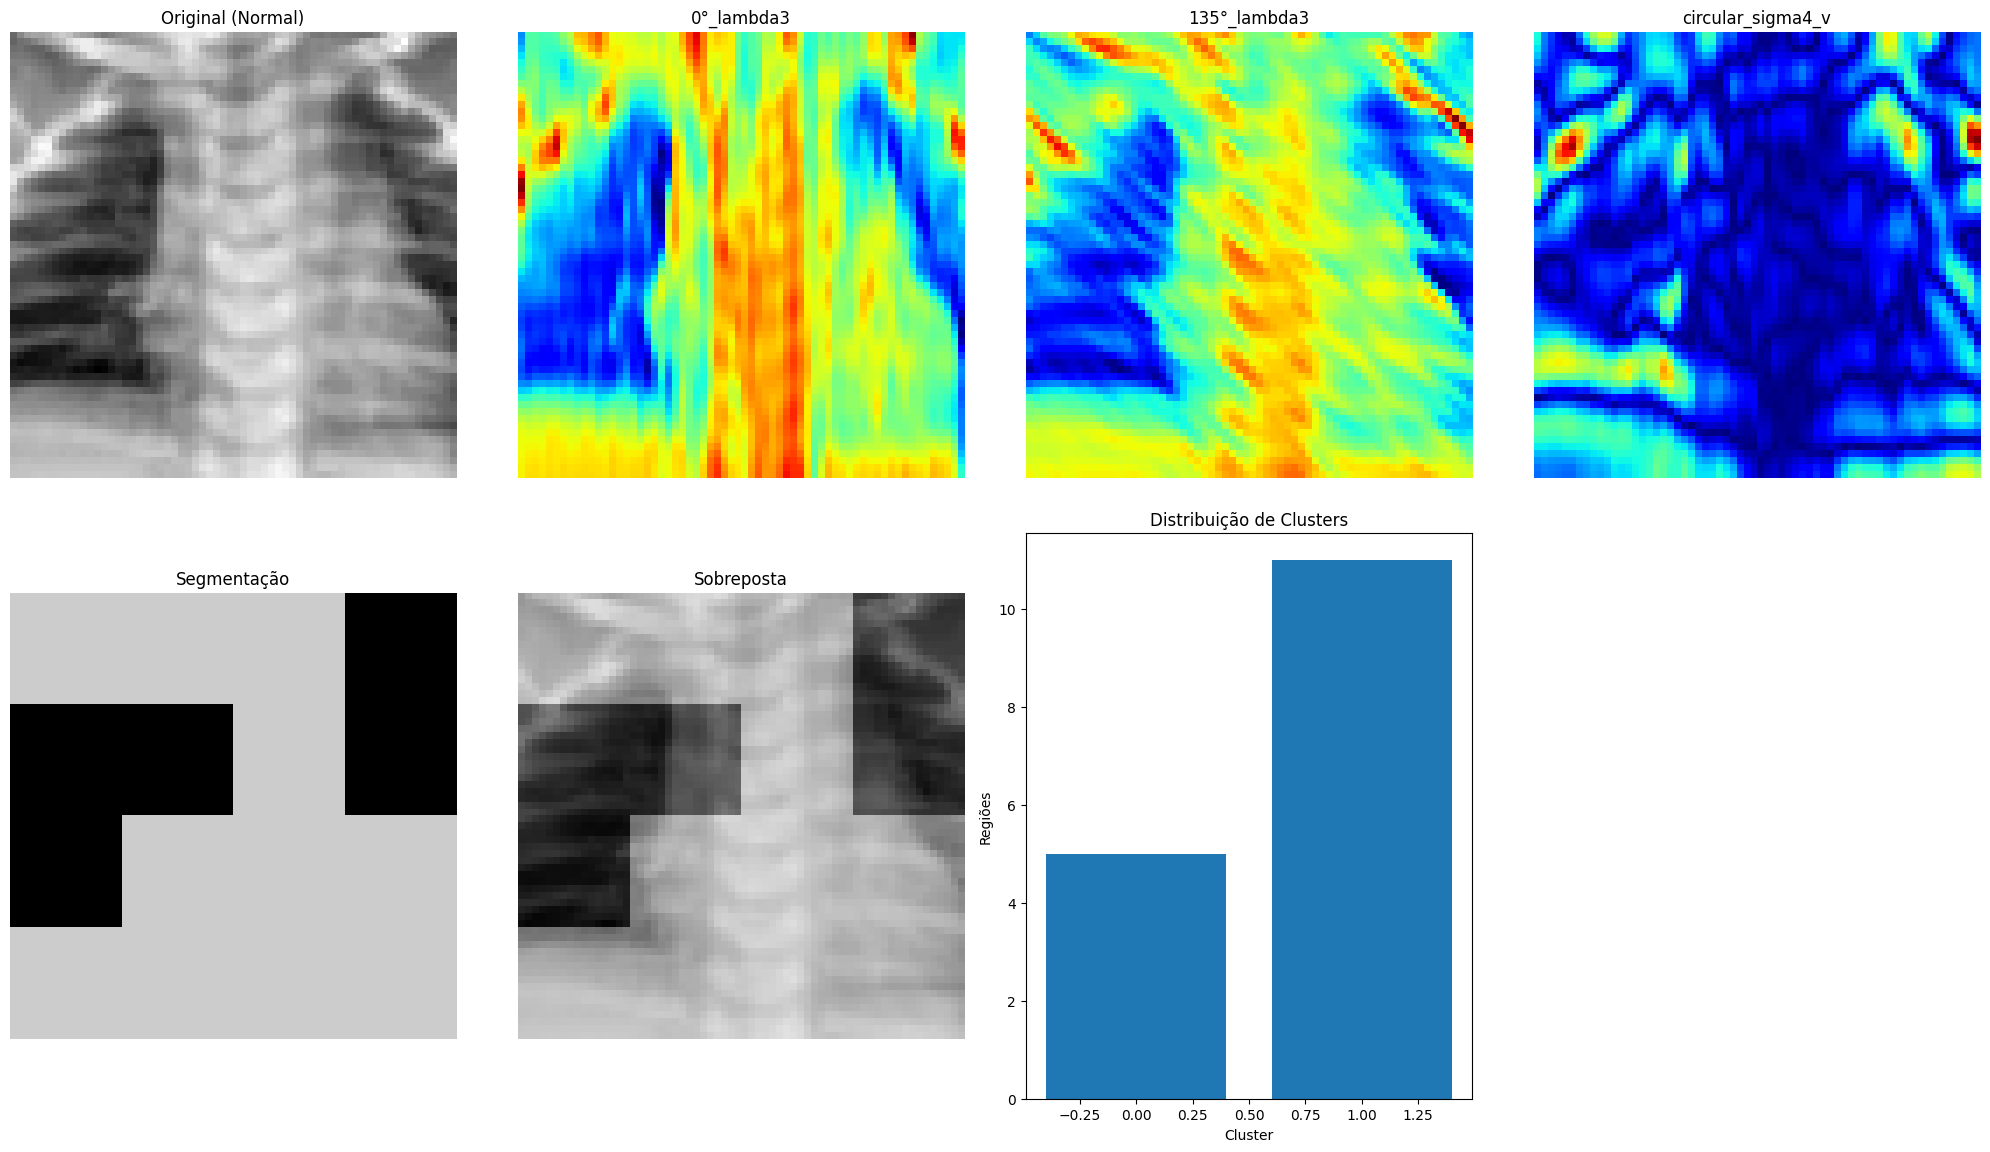

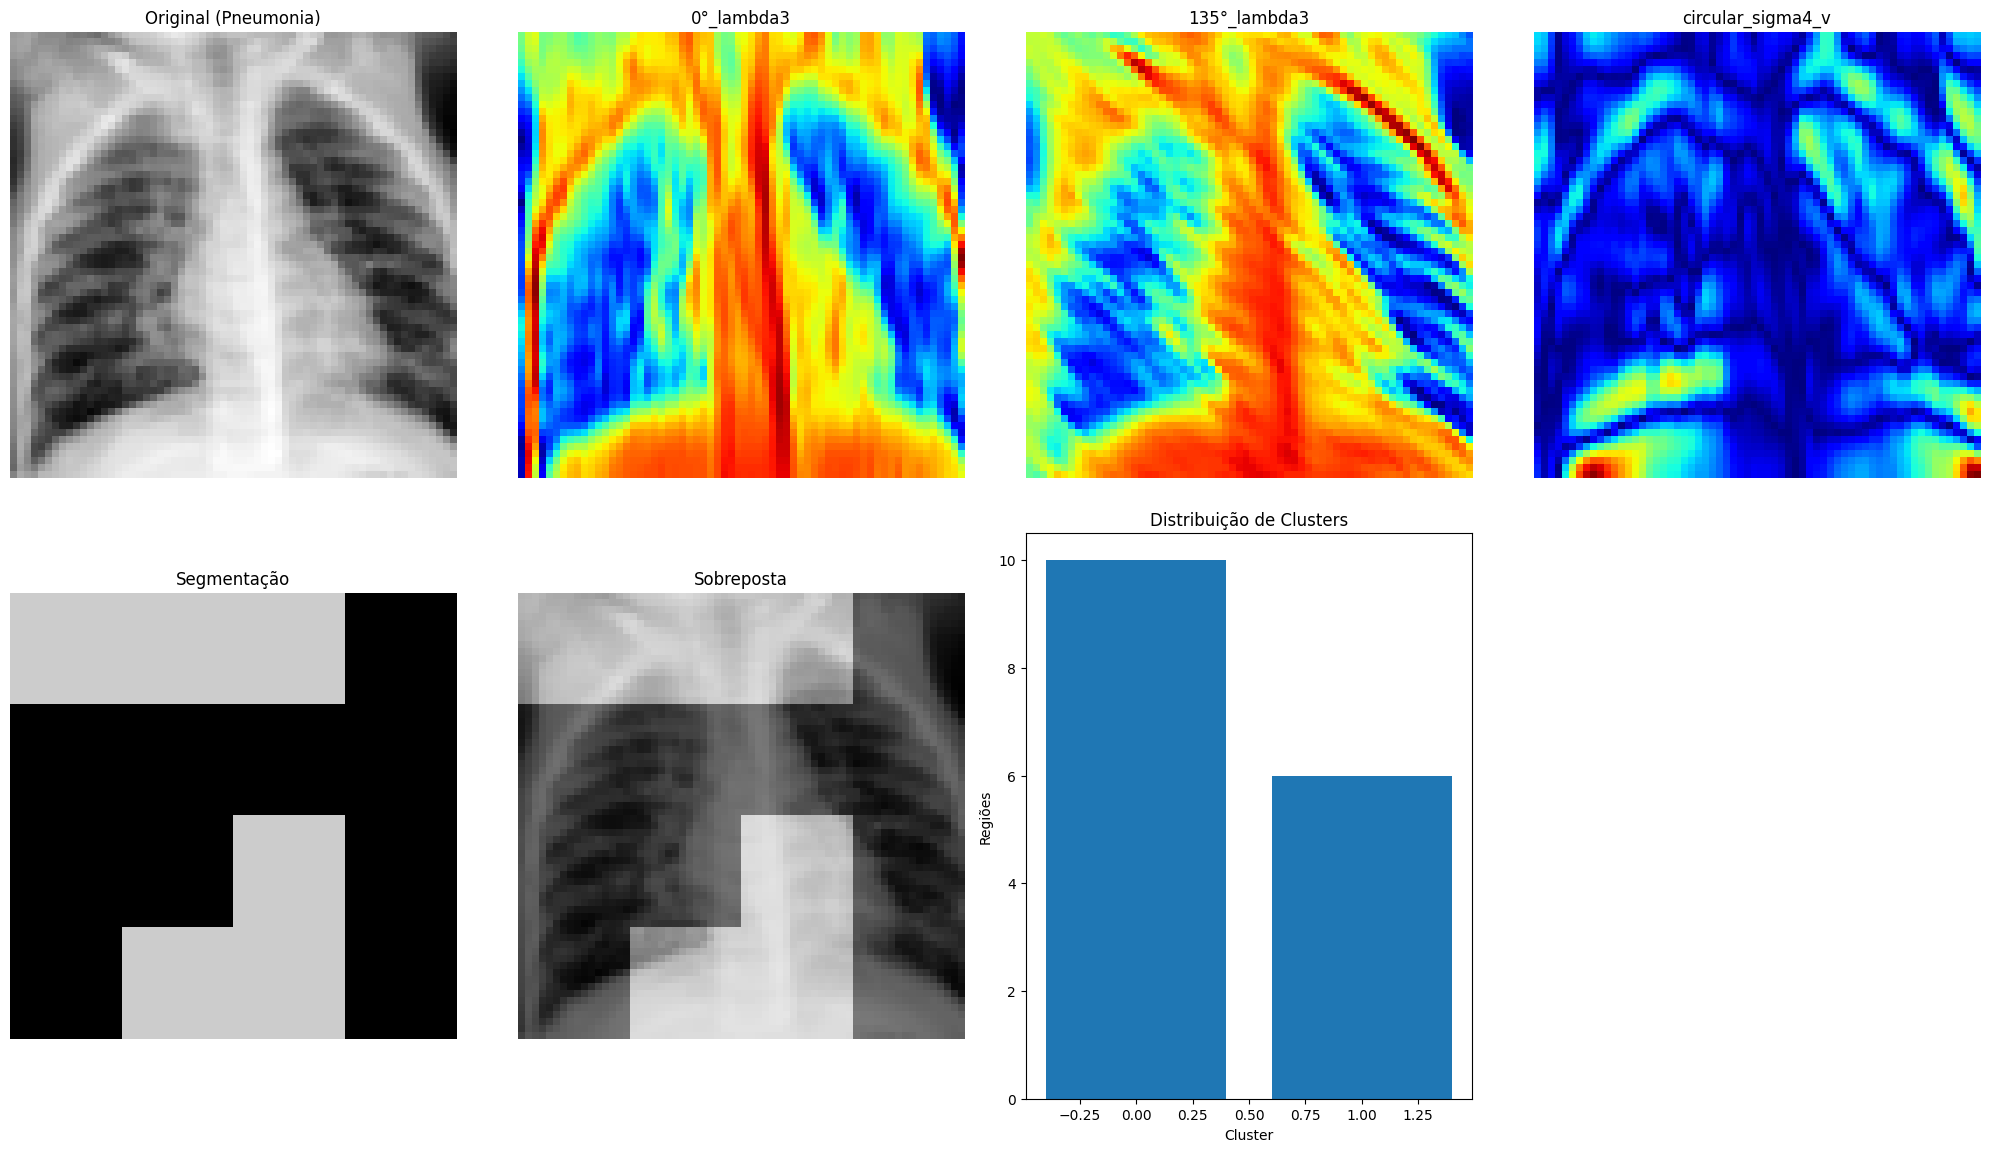

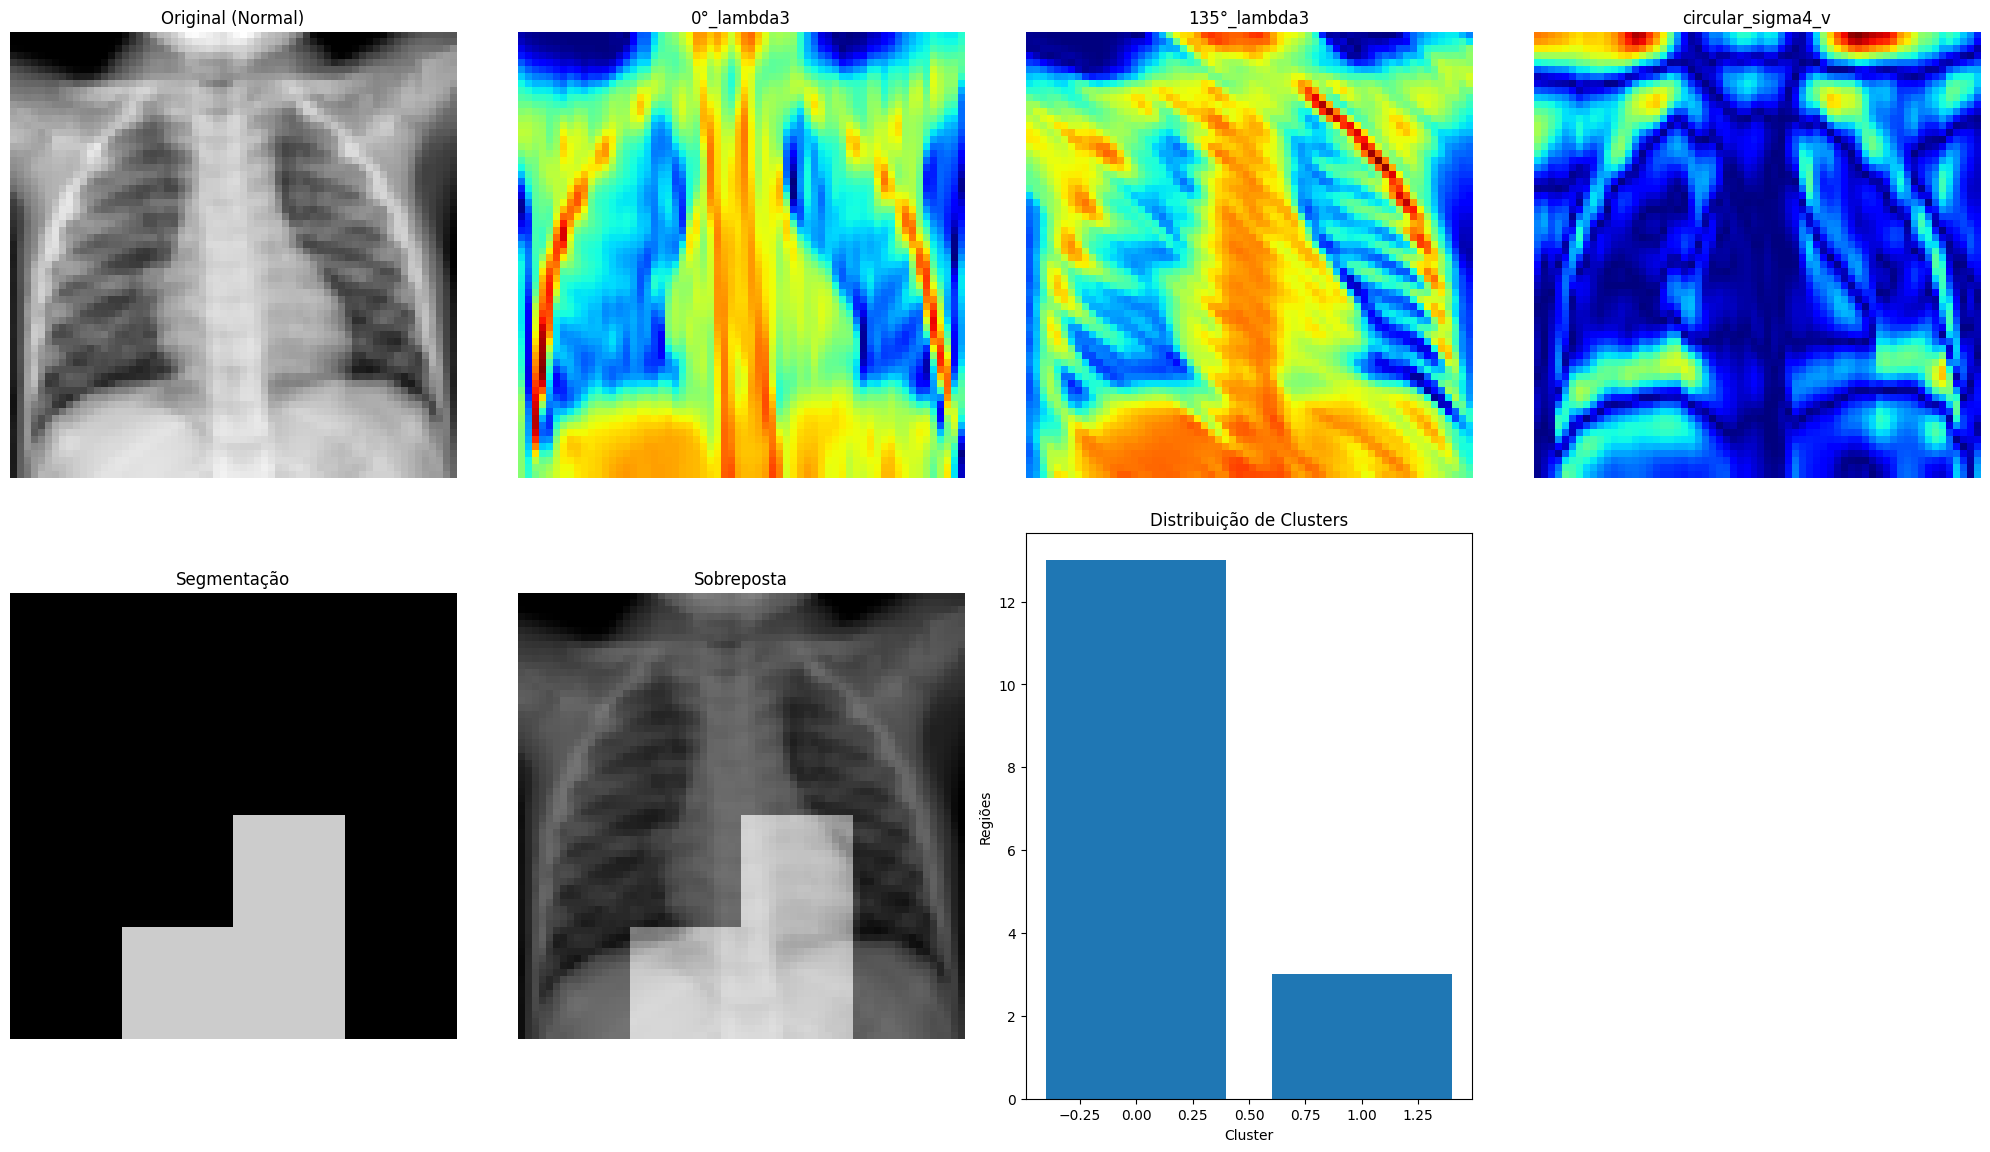

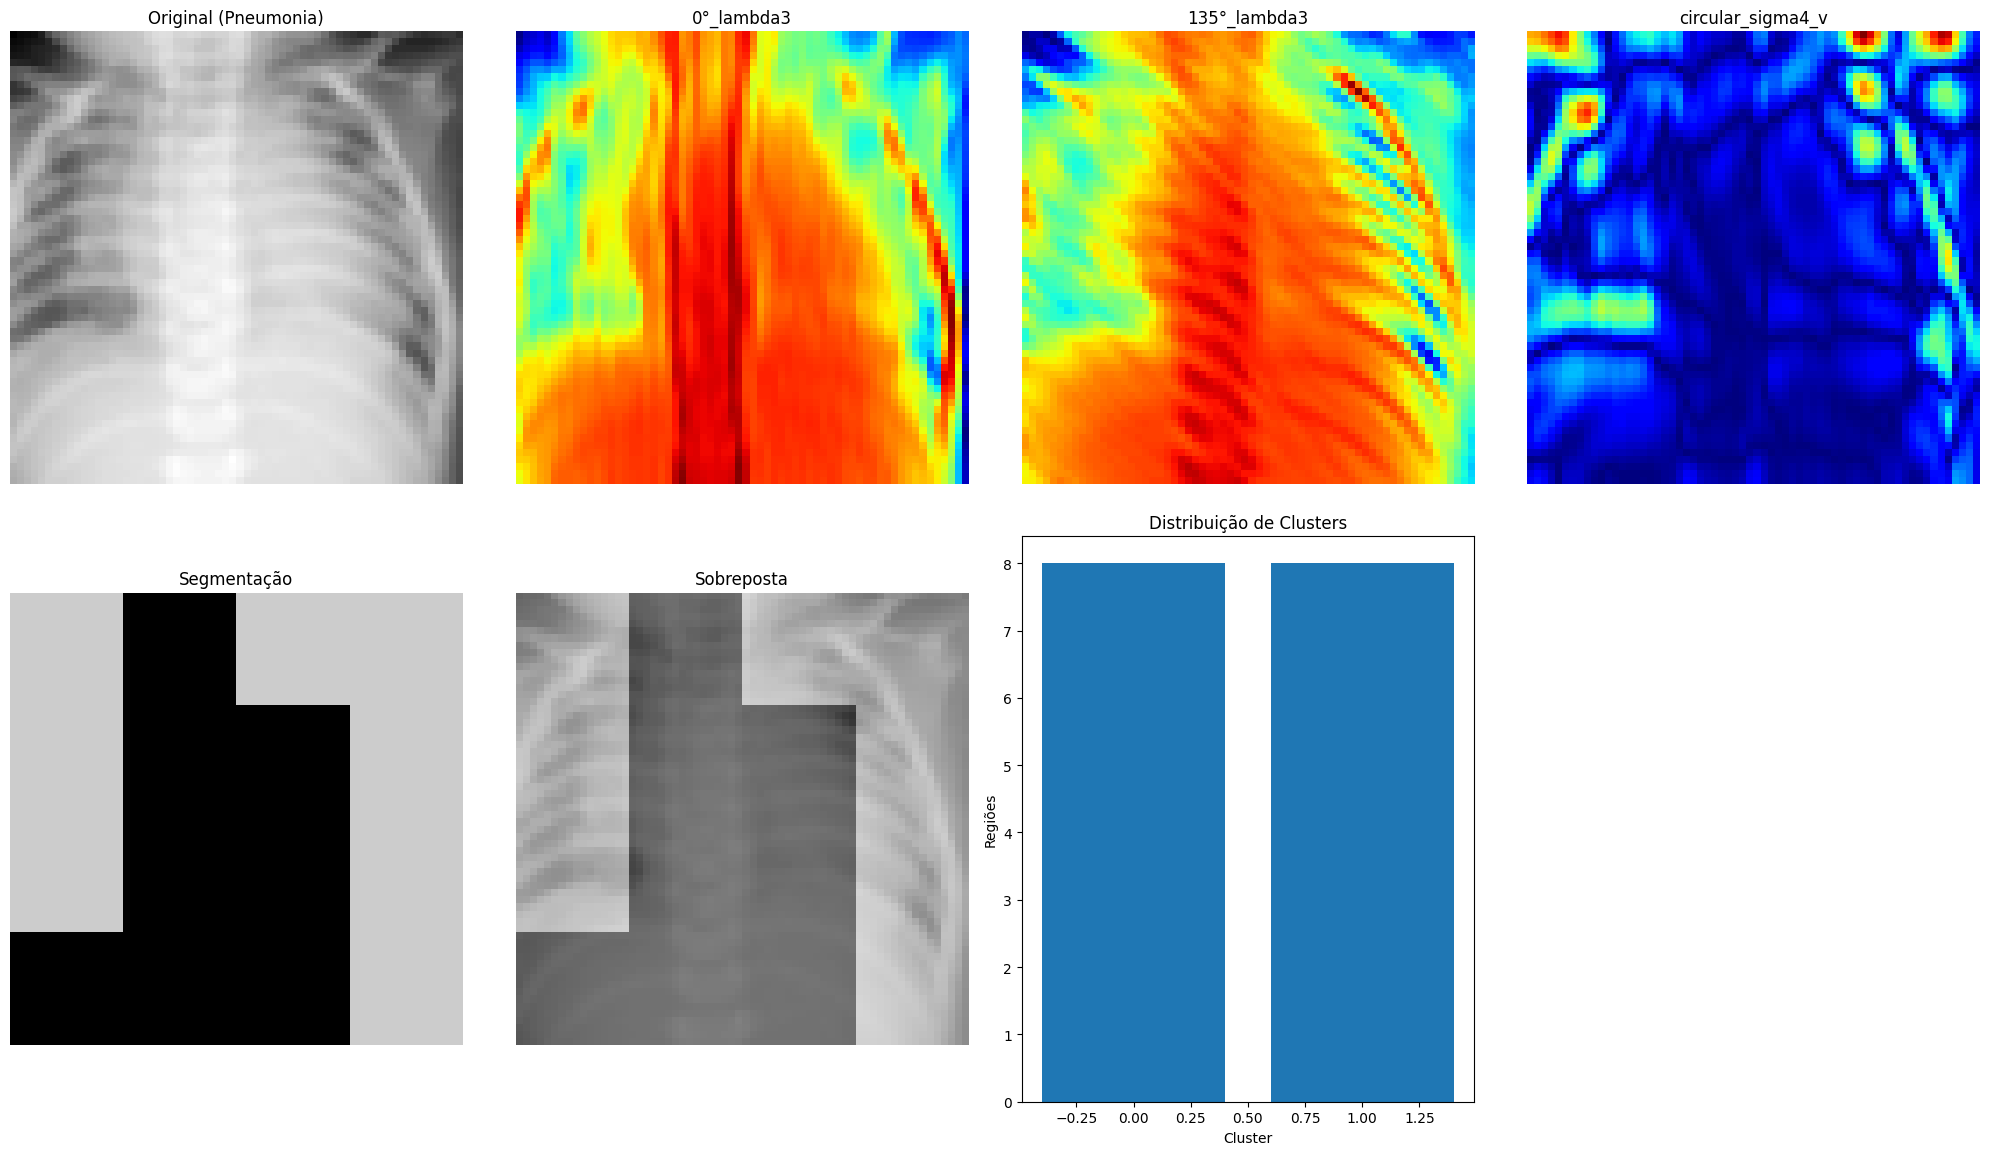

Salvo: imagens/local_avg_dist.png


Salvo: imagens/local_avg_dist.eps


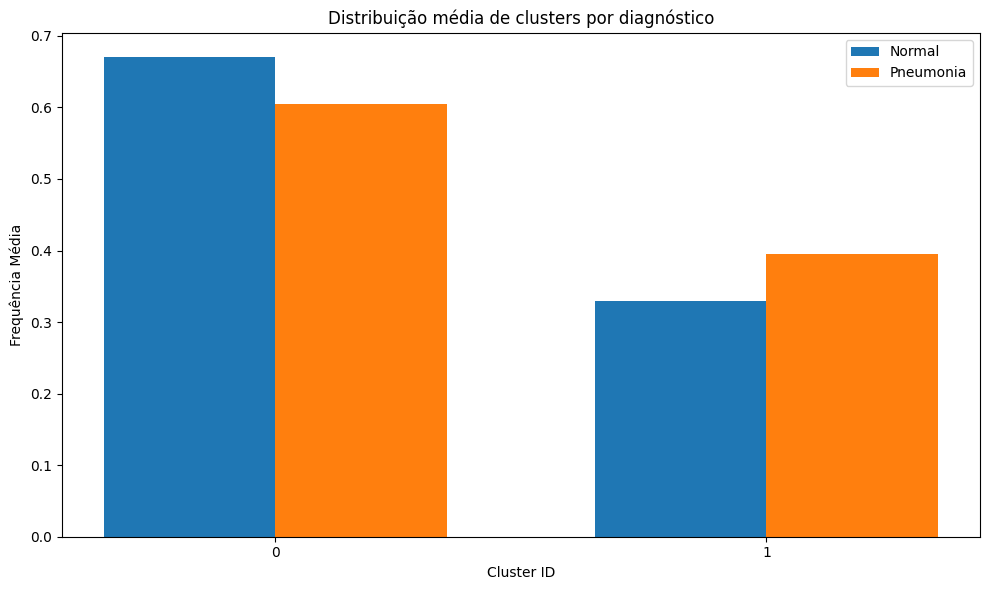

In [8]:
# Carrega datasets
X_train, y_train, X_test, y_test = load_datasets(
    train_amount=200, test_amount=200, size=64
)

# Cria filtros Gabor/LoG
filters = create_gabor_filters()

# Função para realizar K-means local e devolver distribuição + dados para visualização
def local_cluster_distribution(img, filters, n_clusters=N_CLUSTERS):
    # normaliza e extrai características
    img8 = cv2.normalize(img.squeeze(), None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    feats, filtered_images = extract_texture_features(img8, filters)
    # aplica K-means local
    segmented, centroids, kmeans_local, actual_n_clusters = cluster_regions(feats, n_clusters)
    # monta distribuição completa
    unique, counts = np.unique(segmented, return_counts=True)
    full = np.zeros(actual_n_clusters)
    for u, c in zip(unique, counts):
        full[int(u)] = c
    dist = full / full.sum()
    return dist, filtered_images, segmented

# Calcular distribuições de treino (K-means local por imagem)
dists_train = []
for img, label in zip(X_train, y_train):
    dist, _, _ = local_cluster_distribution(img, filters)
    dists_train.append((dist, label))

# separar por classe e truncar ao menor número de clusters comum
min_clust = min(dist.shape[0] for dist, _ in dists_train)
normal_dists    = np.array([d[:min_clust] for d, l in dists_train if l == 0])
pneumonia_dists = np.array([d[:min_clust] for d, l in dists_train if l == 1])

avg_normal    = normal_dists.mean(axis=0)    if len(normal_dists)    else np.zeros(min_clust)
avg_pneumonia = pneumonia_dists.mean(axis=0) if len(pneumonia_dists) else np.zeros(min_clust)

# Predição no teste (K-means local por imagem + comparação de distribuições)
y_pred = []
for img in X_test:
    dist, _, _ = local_cluster_distribution(img, filters)
    dist = dist[:min_clust]
    # atribui label pelo cluster mais próximo das médias
    y_pred.append(
        1 if np.linalg.norm(dist - avg_pneumonia) < np.linalg.norm(dist - avg_normal)
        else 0
    )
y_pred = np.array(y_pred)

# Métricas
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()

print("Matriz de Confusão:")
print(cm)
print(f"\nVerdadeiros Positivos (TP): {tp}")
print(f"Verdadeiros Negativos (TN): {tn}")
print(f"Falsos Positivos    (FP): {fp}")
print(f"Falsos Negativos    (FN): {fn}")

acc = accuracy_score(y_test, y_pred)
print(f"\nAcurácia: {acc*100:.2f}%")

# Visualização em algumas imagens de teste
for idx in range(5):
    img   = X_test[idx]
    label = y_test[idx]
    img8  = cv2.normalize(img.squeeze(), None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    _, filtered_images, segmented = local_cluster_distribution(img, filters)

    prefix = f"local_{idx}_{'pneumonia' if y_test[idx]==1 else 'normal'}"
    visualize_results(
        img8,
        filtered_images,
        segmented,
        y_test[idx]
    )

# Plot da distribuição média de clusters por diagnóstico
plot_avg_cluster_distribution(
    avg_normal,
    avg_pneumonia,
    save_dir=SAVE_DIR,
    prefix='local_avg_dist',
    dpi=300
)


## Teste treinando Kmeans Global



Matriz de Confusão:
[[74  9]
 [30 87]]

Verdadeiros Positivos (TP): 87
Verdadeiros Negativos (TN): 74
Falsos Positivos    (FP): 9
Falsos Negativos    (FN): 30

Acurácia: 80.50%
Salvo: imagens/global_0_pneu.png
Salvo: imagens/global_0_pneu.eps


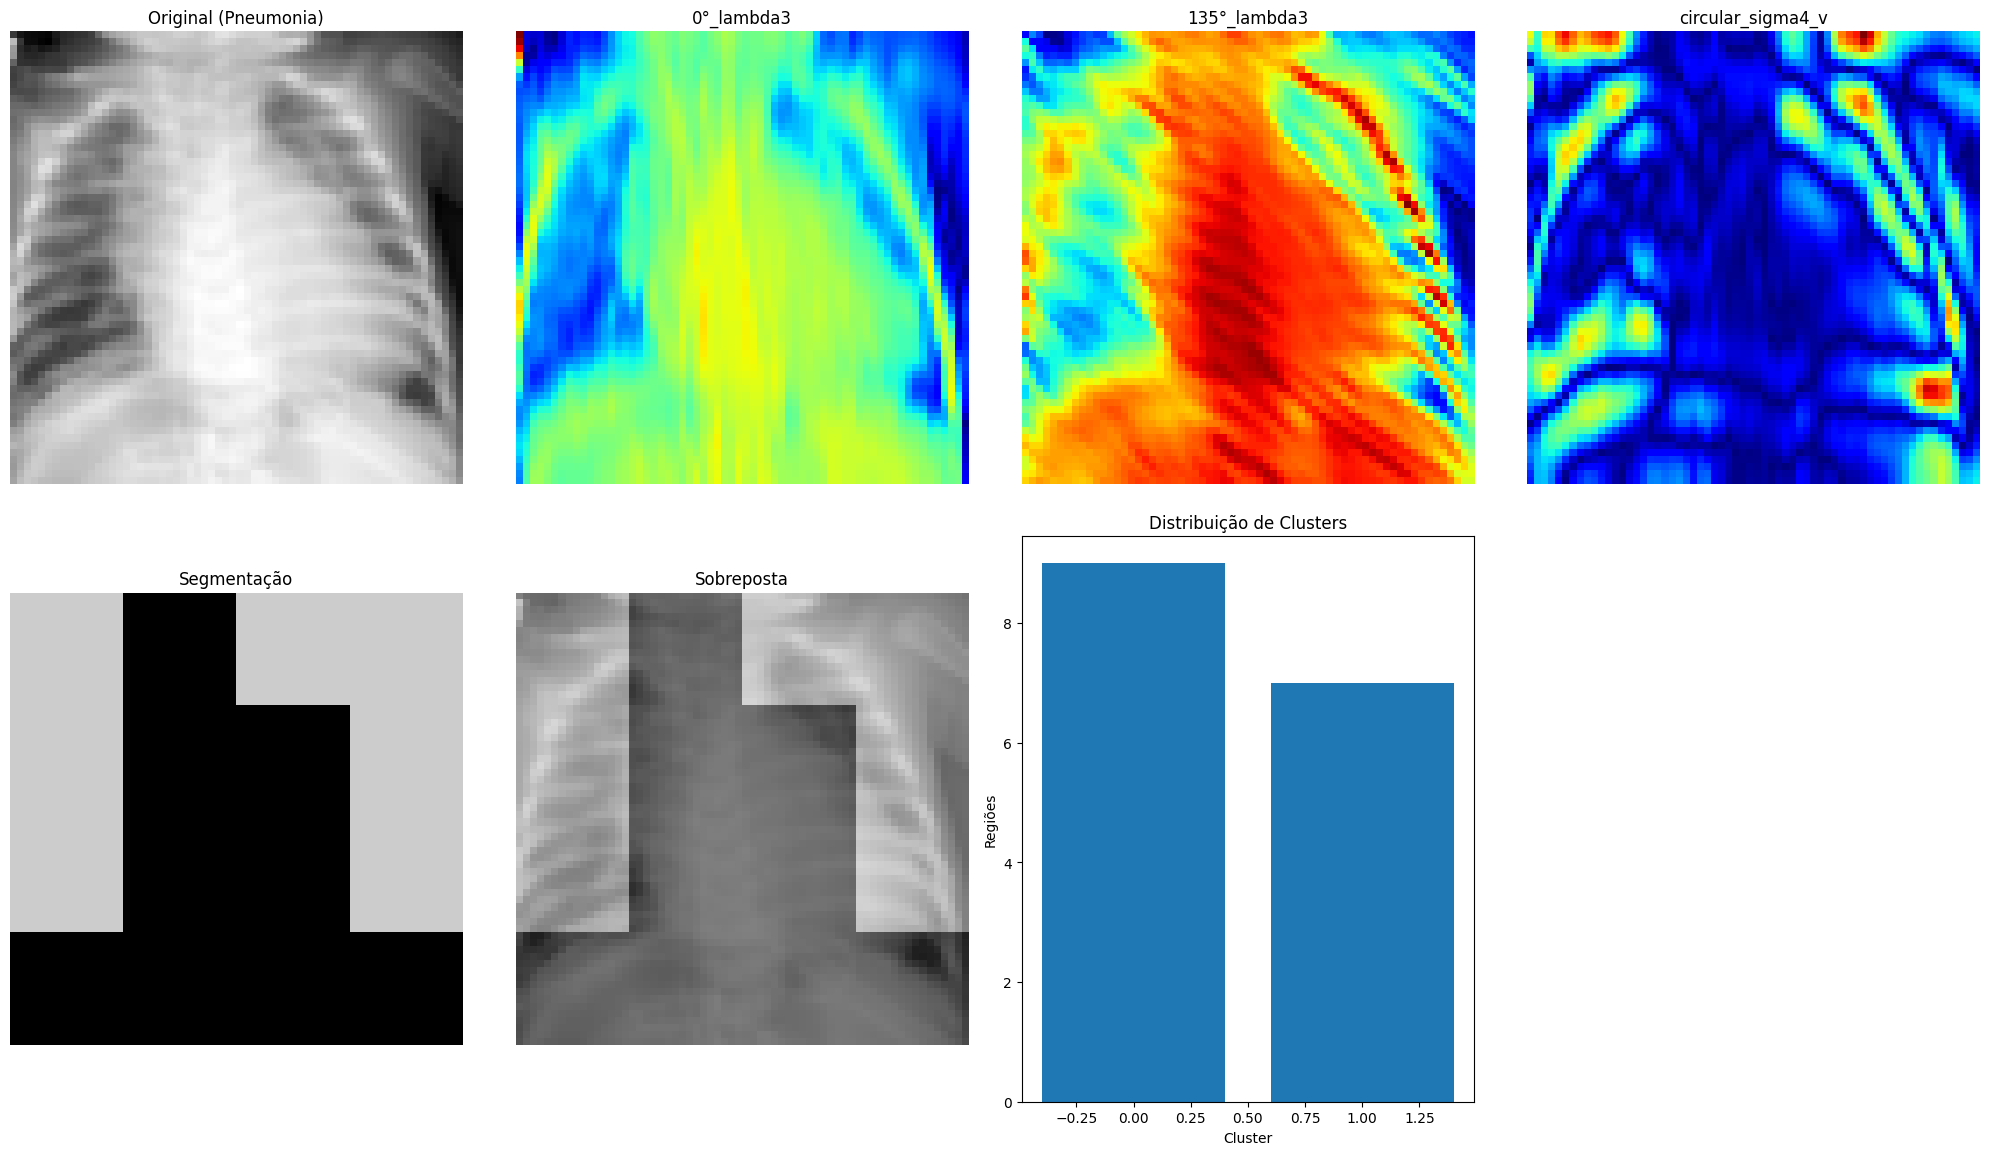

Salvo: imagens/global_1_norm.png
Salvo: imagens/global_1_norm.eps


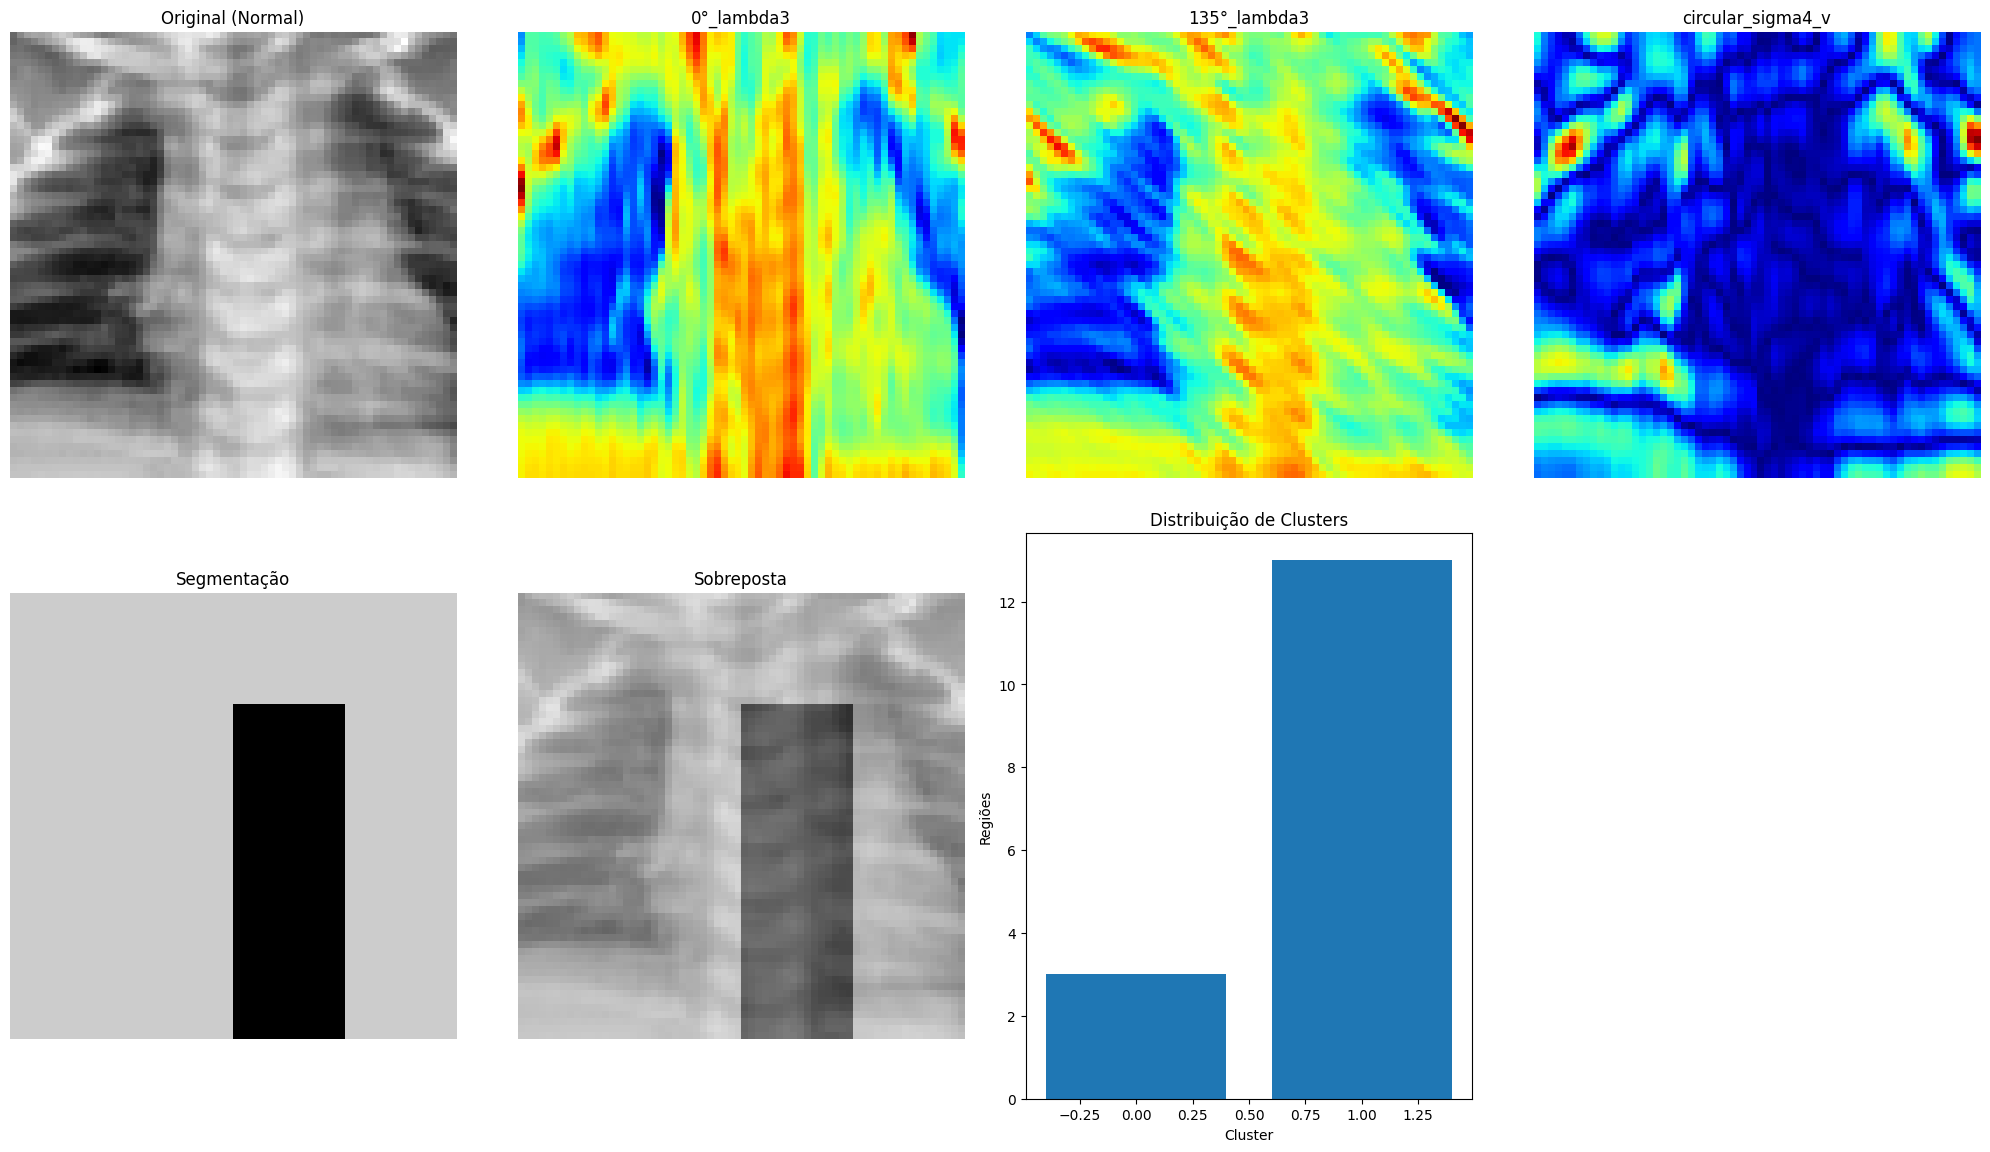

Salvo: imagens/global_2_pneu.png
Salvo: imagens/global_2_pneu.eps


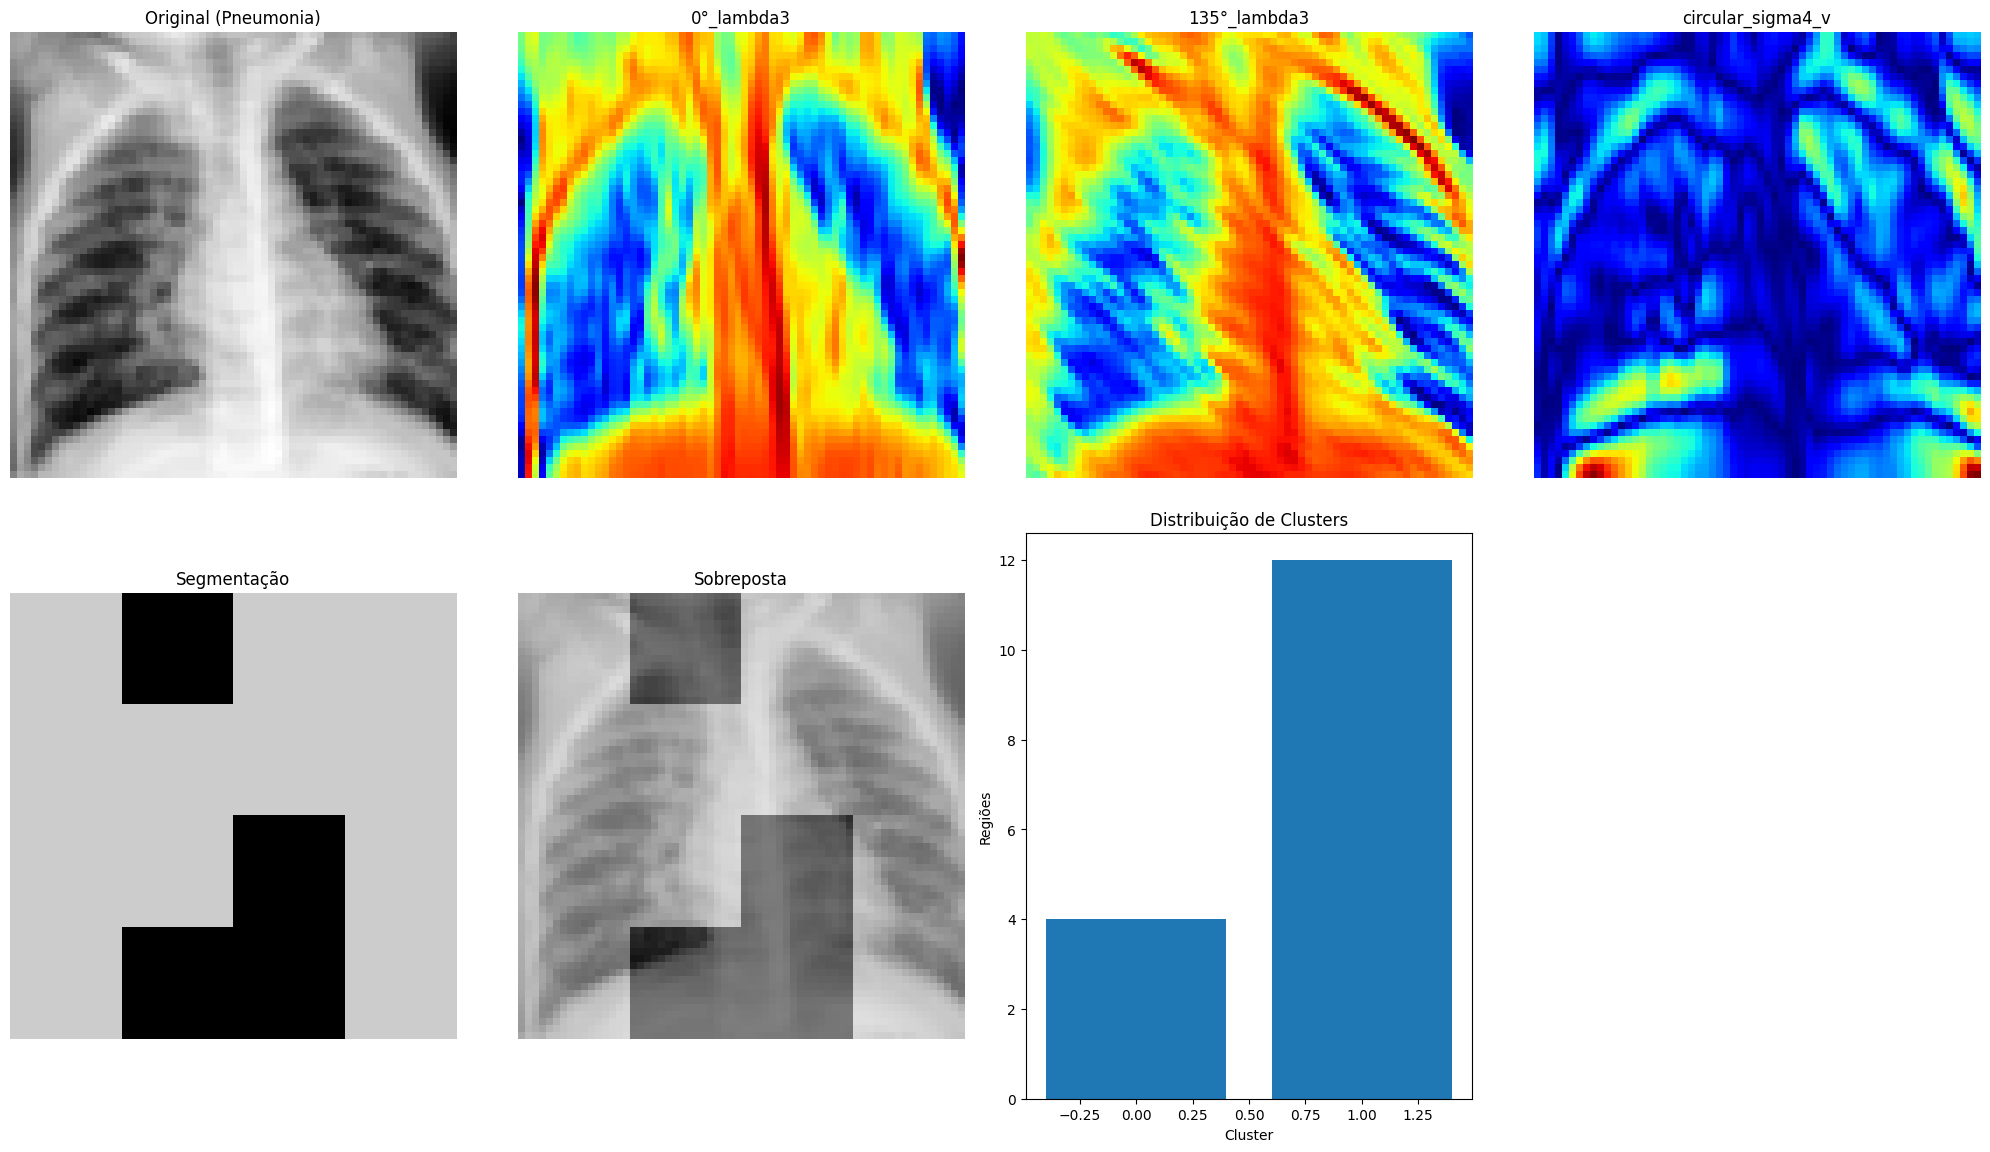

Salvo: imagens/global_3_norm.png
Salvo: imagens/global_3_norm.eps


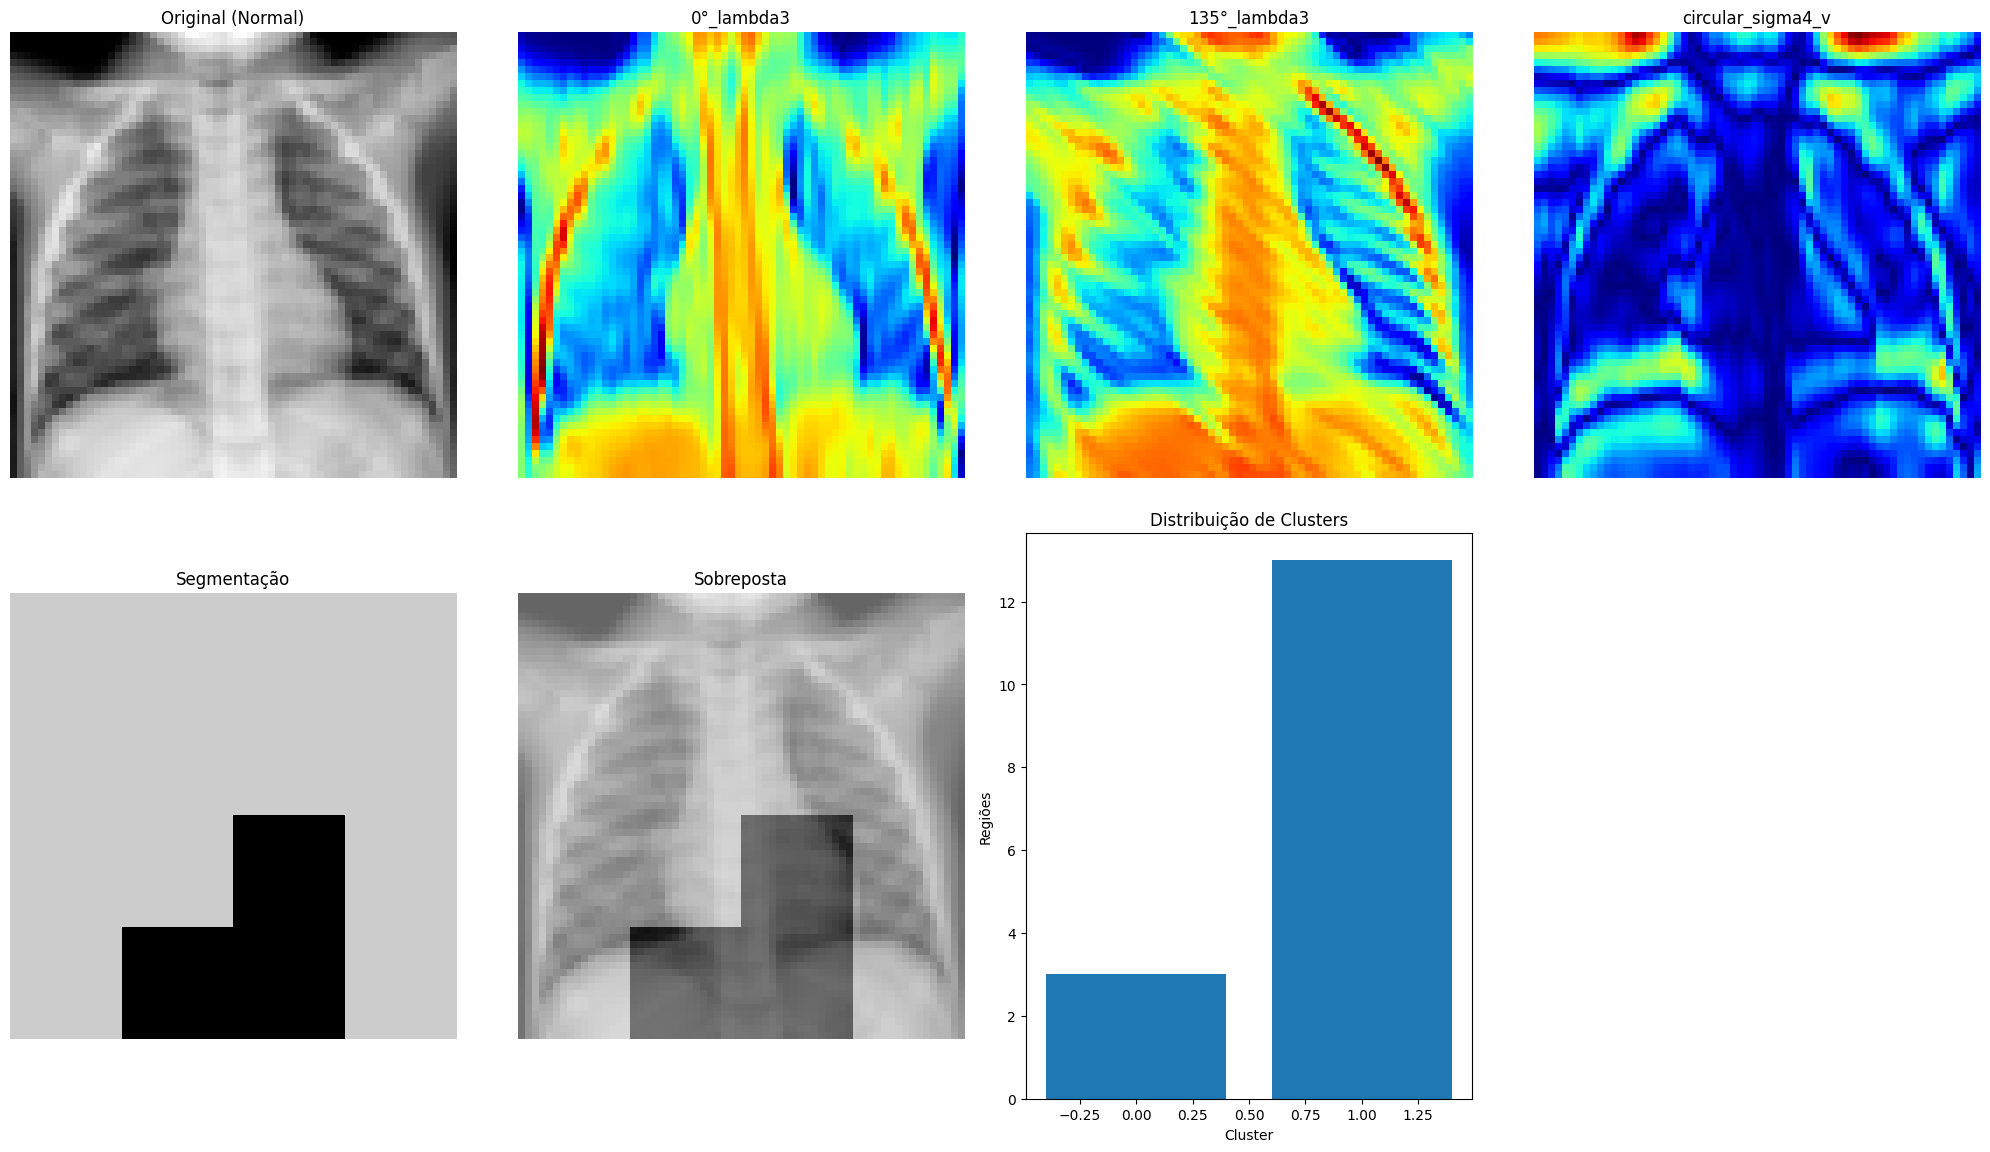

Salvo: imagens/global_4_pneu.png
Salvo: imagens/global_4_pneu.eps


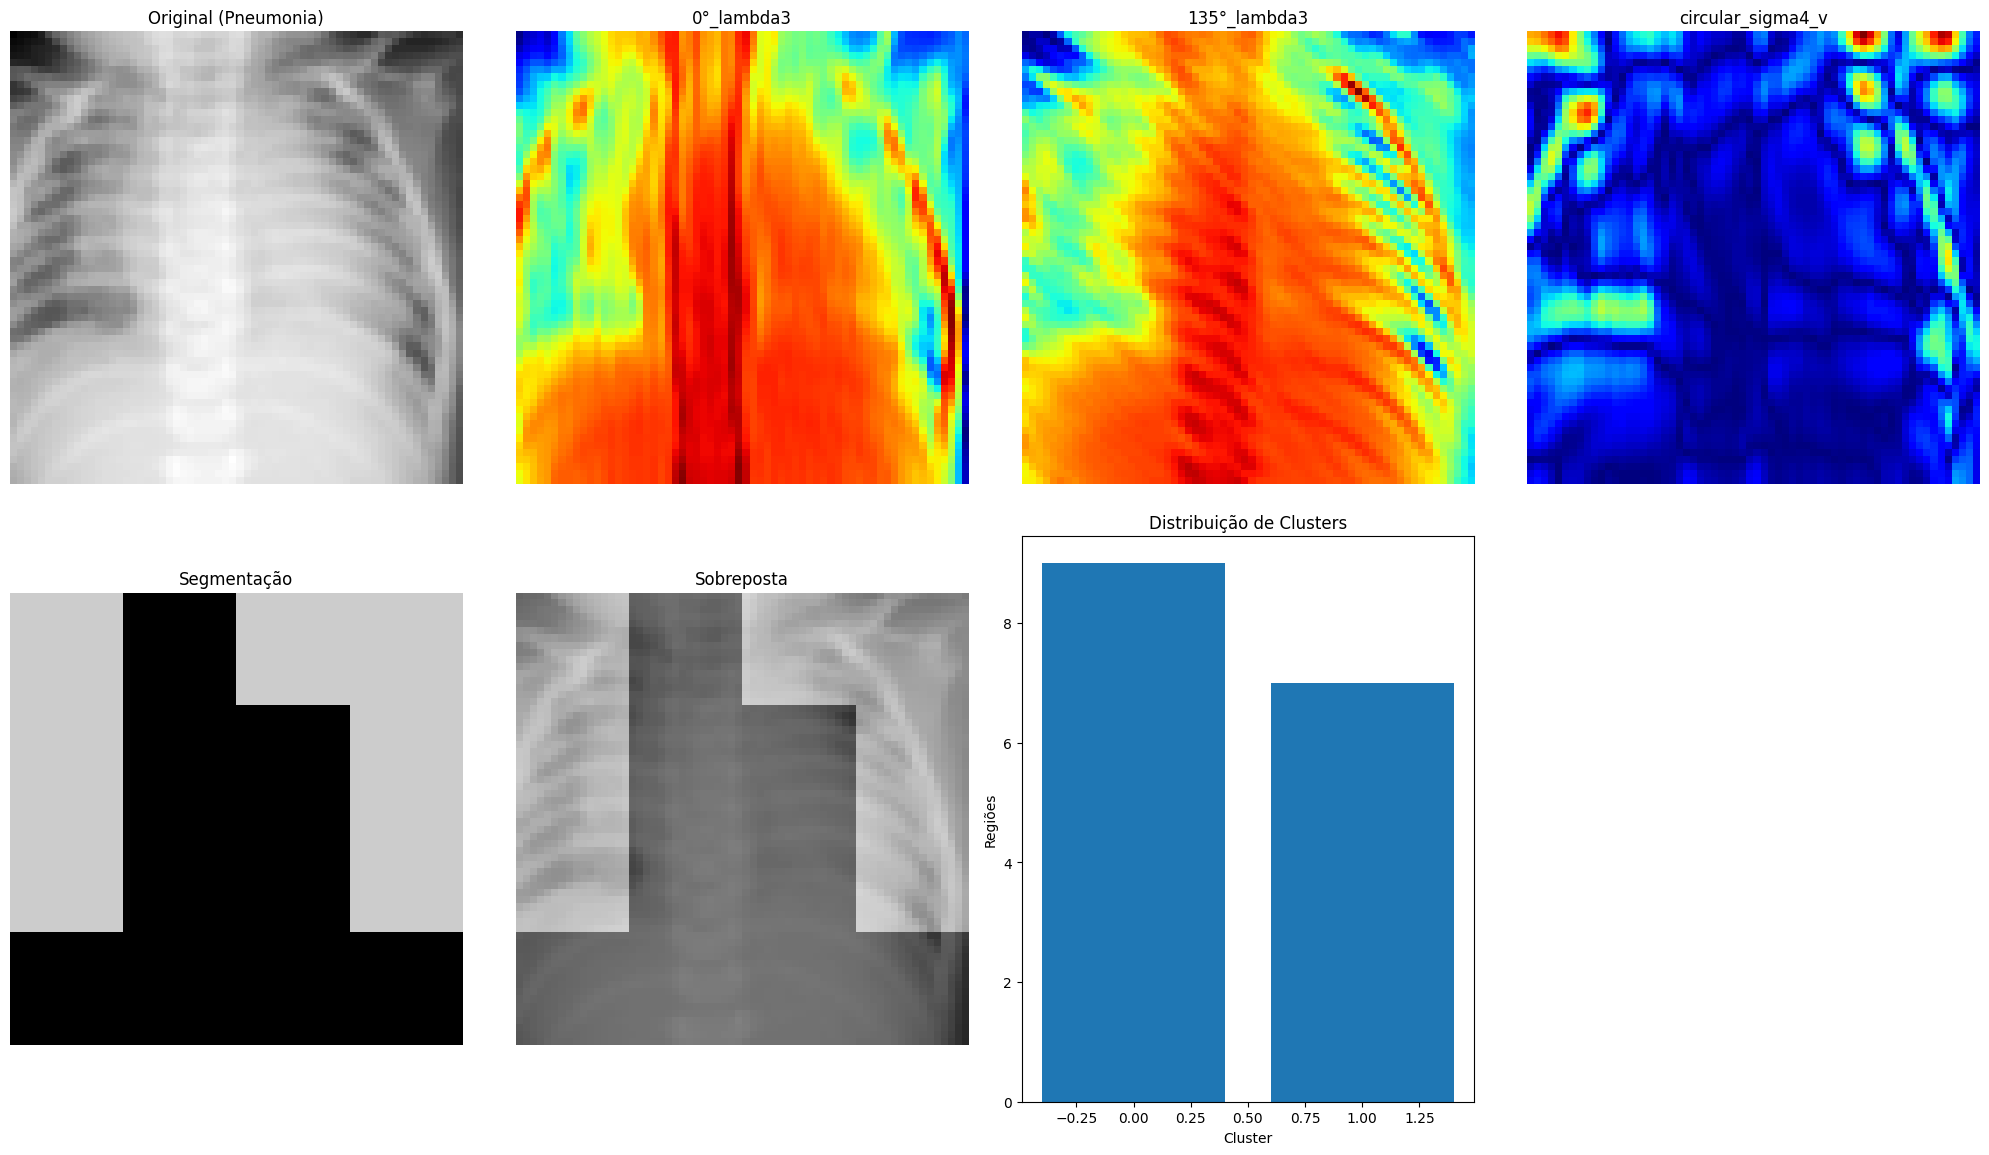

Salvo: imagens/global_avg_dist.png
Salvo: imagens/global_avg_dist.eps


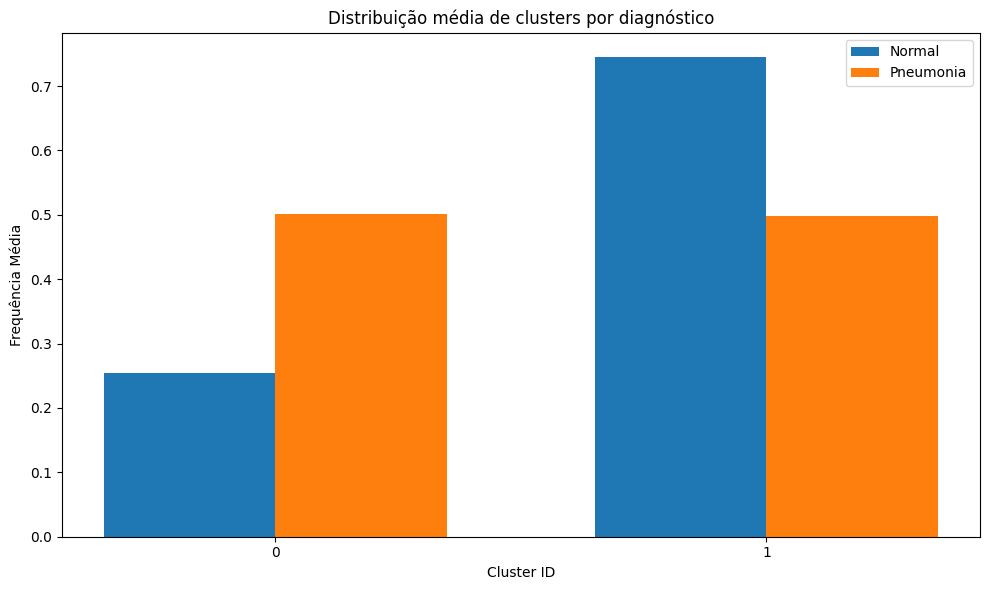

In [9]:
# Carrega
X_train, y_train, X_test, y_test = load_datasets(train_amount=200, test_amount=200)

# Cria filtros Gabor/LoG (reutilizar sua função existente)
filters = create_gabor_filters()

# Prepara features e treina KMeans
feat_train = prepare_training_features(X_train, filters)
kmeans, scaler = train_kmeans_global(feat_train, n_clusters=N_CLUSTERS)

# Calcula distribuições médias por classe no treino
dists_train = np.array([compute_distribution(x, filters, kmeans, scaler) for x in X_train])
avg_normal    = dists_train[y_train==0].mean(axis=0)
avg_pneumonia = dists_train[y_train==1].mean(axis=0)

# Predição no teste usando distância euclidiana
dists_test = np.array([compute_distribution(x, filters, kmeans, scaler) for x in X_test])
y_pred = np.array([
    1 if np.linalg.norm(dist - avg_pneumonia) < np.linalg.norm(dist - avg_normal) else 0
    for dist in dists_test
])

# Confusion matrix e métricas derivadas
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()

print("Matriz de Confusão:")
print(cm)
print(f"\nVerdadeiros Positivos (TP): {tp}")
print(f"Verdadeiros Negativos (TN): {tn}")
print(f"Falsos Positivos    (FP): {fp}")
print(f"Falsos Negativos    (FN): {fn}")

# Acurácia via TP, TN, FP, FN
acc = (tp + tn) / (tp + tn + fp + fn)
print(f"\nAcurácia: {acc*100:.2f}%")

# Visualizar segmentação em algumas imagens de teste
for idx in range(5):
    img = X_test[idx]
    label = y_test[idx]
    img8 = cv2.normalize(img.squeeze(), None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    feats, filtered_images = extract_texture_features(img8, filters)
    h, w, d = feats.shape
    flat = feats.reshape(h*w, d)
    flat_s = scaler.transform(flat)
    preds = kmeans.predict(flat_s)
    segmented = preds.reshape(h, w)

    prefix = f"global_{idx}_{'pneu' if label==1 else 'norm'}"
    visualize_results(
        img8,
        filtered_images,
        segmented,
        label,
        save_dir=SAVE_DIR,
        prefix=prefix
    )

# Plot da distribuição média de clusters por diagnóstico
plot_avg_cluster_distribution(
    avg_normal,
    avg_pneumonia,
    save_dir=SAVE_DIR,
    prefix='global_avg_dist',
    dpi=300
)
